<a href="https://colab.research.google.com/github/Snehaganupa/Snehaganupa/blob/main/phishing_hybrid_cnn_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Phishing Detection: CNN + LSTM + Random Forest
Combines character-level deep learning with feature-based Random Forest for robust phishing URL classification.

In [ ]:
!pip install tensorflow scikit-learn pandas numpy --quiet

In [ ]:

import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:

df = pd.read_csv("/content/phish_legit_site_urls.csv")
df["label"] = df["Label"].map({"bad": 1, "good": 0})
df.drop(columns=["Label"], inplace=True)
df = df[df["URL"].str.len() > 10]
phish = df[df.label == 1].sample(n=100000, random_state=42)
legit = df[df.label == 0].sample(n=100000, random_state=42)
df_balanced = pd.concat([phish, legit], ignore_index=True).sample(frac=1, random_state=42)


In [ ]:

urls = df_balanced["URL"].astype(str).values
labels = df_balanced["label"].values
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
MAX_LEN = 200
X_cnn = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")
vocab_size = len(tokenizer.word_index) + 1


In [ ]:

def safe_parse(url):
    try:
        if not url.startswith(("http://", "https://")):
            url = "http://" + url
        return urlparse(url)
    except:
        return urlparse("http://invalid.url")

suspicious_words = ['login', 'secure', 'account', 'update', 'free', 'verify', 'bank', 'paypal']
def extract_features(url):
    parsed = safe_parse(url)
    domain = parsed.netloc or ""
    path = parsed.path + parsed.query
    try:
        entropy_val = round(-sum(p * np.log2(p) for p in [float(url.count(c)) / len(url) for c in set(url)] if p > 0), 5)
    except:
        entropy_val = 0
    return {
        "url_length": len(url),
        "domain_length": len(domain),
        "path_length": len(path),
        "num_dots": url.count('.'),
        "num_hyphens": url.count('-'),
        "num_slashes": url.count('/'),
        "num_at": url.count('@'),
        "has_https": int(url.startswith("https")),
        "has_ip": int(bool(re.search(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', domain))),
        "starts_with_ip": int(bool(re.match(r'^(http[s]?://)?(\d{1,3}\.){3}\d{1,3}', url))),
        "contains_suspicious_word": int(any(word in url.lower() for word in suspicious_words)),
        "has_double_slash_redirect": int('//' in path.strip('/')),
        "num_params": url.count('&') + url.count('?'),
        "entropy": entropy_val,
    }

features_df = df_balanced["URL"].apply(extract_features).apply(pd.Series)
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=300)
X_tfidf = tfidf.fit_transform(df_balanced["URL"])
X_smart = features_df
X_rf = hstack([X_tfidf, X_smart])


In [ ]:

y = labels
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)
X_train_rf, X_test_rf, _, _ = train_test_split(X_rf, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=MAX_LEN))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(LSTM(64))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train_cnn, y_train, validation_split=0.1, epochs=30, batch_size=256, callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5629 - loss: 0.6541 - val_accuracy: 0.8016 - val_loss: 0.4263
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8156 - loss: 0.3976 - val_accuracy: 0.8649 - val_loss: 0.3128
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8798 - loss: 0.2857 - val_accuracy: 0.9054 - val_loss: 0.2341
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9095 - loss: 0.2231 - val_accuracy: 0.9199 - val_loss: 0.2034
Epoch 5/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9247 - loss: 0.1905 - val_accuracy: 0.9044 - val_loss: 0.2441
Epoch 6/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9318 - loss: 0.1718 - val_accuracy: 0.9389 - val_loss: 0.1598
Epoch 7/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9389 - loss: 0.1557 - val_accuracy: 0.9454 - val_loss: 0.1500
Epoch 8/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9476 - loss: 0.1372 - v

In [12]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)


RandomForestClassifier(random_state=42)

In [13]:

cnn_probs = cnn_model.predict(X_test_cnn).flatten()
rf_probs = rf_model.predict_proba(X_test_rf)[:, 1]

# Weighting 50-50
hybrid_probs = 0.5 * cnn_probs + 0.5 * rf_probs
hybrid_preds = (hybrid_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, hybrid_preds))
print("Precision:", precision_score(y_test, hybrid_preds))
print("Recall:", recall_score(y_test, hybrid_preds))
print("F1 Score:", f1_score(y_test, hybrid_preds))
print("\nClassification Report:\n", classification_report(y_test, hybrid_preds, target_names=["Legitimate", "Phishing"]))


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Accuracy: 0.965775
Precision: 0.9725082424549835
Recall: 0.95865
F1 Score: 0.9655293969532922

Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.96      0.97      0.97     20000
    Phishing       0.97      0.96      0.97     20000

    accuracy                           0.97     40000
   macro avg       0.97      0.97      0.97     40000
weighted avg       0.97      0.97      0.97     40000



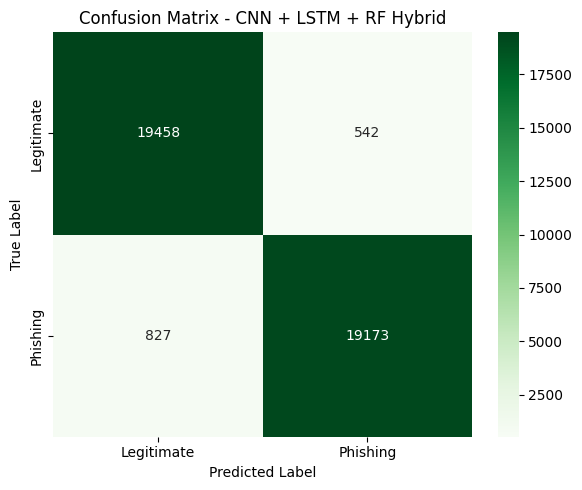

In [14]:

cm = confusion_matrix(y_test, hybrid_preds)
labels = ["Legitimate", "Phishing"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN + LSTM + RF Hybrid")
plt.tight_layout()
plt.show()
